In [1]:
import pandas as p
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.experimental.list_physical_devices('GPU'))

In [2]:
%store -r data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   target      1600000 non-null  int64 
 1   ids         1600000 non-null  int64 
 2   date        1600000 non-null  object
 3   flag        1600000 non-null  object
 4   user        1600000 non-null  object
 5   text        1600000 non-null  object
 6   clean_text  1600000 non-null  object
dtypes: int64(2), object(5)
memory usage: 85.4+ MB


In [3]:
X = data['clean_text'].values
y = data['target'].values
y = np.array([i if i == 0 else 1 for i in y])
print(len(X))
print(len(y))

1600000
1600000


In [4]:
X_train, X_validation_test, y_train, y_validation_test = train_test_split(X, y, test_size=0.02, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation_test, y_validation_test, test_size=0.5, random_state=0)
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)
np.unique(y_train, return_counts=True)

(1568000,) (1568000,) (16000,) (16000,) (16000,) (16000,)


(array([0, 1], dtype=int64), array([783999, 784001], dtype=int64))

In [5]:
vectorizer = TfidfVectorizer(encoding='latin-1')
X_train_vec = vectorizer.fit_transform(X_train)
print("X_train_vec shape - ", X_train_vec.shape, "\n")
X_validation_vec = vectorizer.transform(X_validation)
print("X_validation_vec shape - ", X_validation_vec.shape, "\n")
X_test_vec = vectorizer.transform(X_test)
print("X_test_vec shape - ", X_test_vec.shape, "\n")

X_train_vec shape -  (1568000, 242185) 

X_validation_vec shape -  (16000, 242185) 

X_test_vec shape -  (16000, 242185) 



In [7]:
clf = LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1)
clf.fit(X_train_vec, y_train)
clf.score(X_test_vec, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.3min finished


0.8018125

In [6]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter = 0
    index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[index_batch]
        counter += 1
        yield (X_batch, y_batch)
        if (counter > number_of_batches):
            np.random.shuffle(index)
            counter = 0

In [7]:
def plot_graphs(history, string):
  plt.plot(range(1, len(history.history[string])+1), history.history[string])
  plt.plot(range(1, len(history.history['val_'+string])+1), history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [11]:
def save_model(model, name):
    model_json = model.to_json()
    with open(name + '.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(name + '.h5')
    print('Saved model to disk')

In [7]:
def load_model(name):
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights(name + '.h5')
    print('Loaded model from disk')
    return loaded_model

In [8]:
# compile model
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Dense(128, activation='relu', input_dim=X_train_vec.shape[1]))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               30999808  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 30,999,937
Trainable params: 30,999,937
Non-trainable params: 0
_________________________________________________________________


In [9]:
# train model
num_epochs = 2
history1 = model1.fit(batch_generator(X_train_vec, y_train, 256),
                    epochs=num_epochs, validation_data=(X_validation_vec.toarray(), y_validation),
                    steps_per_epoch=X_train_vec.shape[0]/256)

  ...
    to  
  ['...']
Train for 6125.0 steps, validate on 16000 samples
Epoch 1/2
6125/6125 [==============================] - 2478s 405ms/step - loss: 0.4365 - accuracy: 0.7963 - val_loss: 0.4189 - val_accuracy: 0.8075
Epoch 2/2
6125/6125 [==============================] - 2383s 389ms/step - loss: 0.3833 - accuracy: 0.8265 - val_loss: 0.4159 - val_accuracy: 0.8116


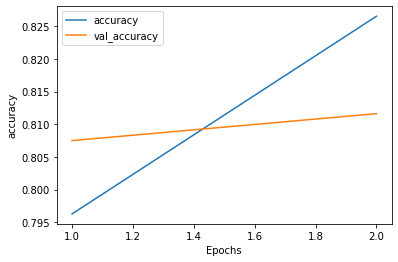

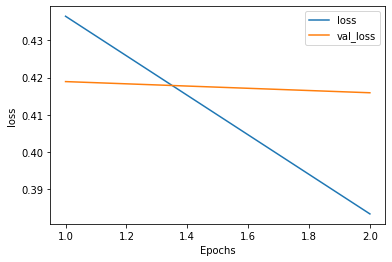

In [10]:
# plot model
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

In [ ]:
# evaluate model
scores1 = model1.evaluate(X_test_vec.toarray(), y_test)
print("%s: %.2f%%" % (model1.metrics_names[1], scores1[1]*100))

In [16]:
# save model
save_model(model1, 'modelNeuralNet')

Saved model to disk


In [8]:
# load model
loaded_model = load_model('modelNeuralNet')

# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test_vec.toarray(), y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
16000/16000 [==============================] - 31s 2ms/sample - loss: 0.4200 - accuracy: 0.8117
accuracy: 81.17%
